In [ ]:
# Import the init_paths module
from init_paths import (
    PROJECT_ROOT,
    DATASETS_DIR,
    ANALYSIS_DIR,
    EXPERIMENTS_DIR,
    IMAGES_DIR,
    GEN_DATA_DIR,
    LOGS_DIR,
    get_project_path
)

Paths initialized successfully. You can now use PROJECT_ROOT, DATASETS_DIR, etc.


In [2]:
import pandas as pd
import sys
from pathlib import Path
import os
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import pickle
import os
import re

In [3]:
from analysis.unsupervised import *
from analysis.supervised import *
from analysis.models import * 
from analysis.Probes import * 
from analysis.models import *

In [4]:
def save_probe_results(publication, model_name, probe_type, accuracy, lower_bound, upper_bound, layer_nr, conf_matrix=None, save_path=None):
    """
    Save probe results (accuracy, confidence intervals, and confusion matrix) to a CSV file.
    
    Parameters:
    -----------
    project_root : Path
        Root path of the project
    publication : str
        Name of the publication
    model_name : str
        Name of the model
    probe_type : str
        Type of probe (e.g., 'linear', 'mlp', etc.)
    accuracy : float
        Accuracy score of the probe
    lower_bound : float
        Lower bound of confidence interval
    upper_bound : float
        Upper bound of confidence interval
    conf_matrix : numpy.ndarray
        Confusion matrix
    save_path : str or Path
        Path where the probe model is saved
    """
    # Define path for results
    path = DATASETS_DIR / f"{publication}/{model_name}/{model_name}_probe_accuracies.csv"
    
    if conf_matrix is not None: 
        # Convert confusion matrix to string representation
        conf_matrix = np.array2string(conf_matrix, separator=';')
        
    # Create DataFrame with results
    results_df = pd.DataFrame({
        "type of probe": [probe_type],  
        "layer_nr": [layer_nr],
        "accuracy": [accuracy],
        "lower_bound": [lower_bound],
        "upper_bound": [upper_bound],
        "conf_matrix": [conf_matrix],
        "probe_path": [save_path]
    })
    
    
    # Save to CSV - create new file if it doesn't exist, append if it does
    if not os.path.exists(path):
        results_df.to_csv(path, index=False)
    else:
        results_df.to_csv(path, index=False, mode='a', header=False)

# Load data

In [5]:
publication = ["public_1", "public_2"][1]

folder_path = DATASETS_DIR/ f"prompt_activations/{publication}/"
files = os.listdir(folder_path)

models_list = list(models.keys())
model = models_list[3]
print(model)

for file in files:
    
    if file.endswith(".pkl") and "rated" in file and model in file: 
      print(file)
      path = folder_path / file

      df = pd.read_pickle(path)
      # for each row, if original_prompt_text is in output_text, remove original prompt text


Ministral-8B-Instruct
_mistralaiMinistral-8B-Instruct-2410_prompt_res_activations_2102202513:08:05_rated.pkl


In [6]:
df.columns

Index(['prompt_name', 'jailbreak_prompt_name', 'jailbreak_prompt_text',
       'original_prompt_text', 'prompt_res_activations', 'output_text',
       'rating_output_text'],
      dtype='object')

In [7]:
model_name, num_layers, rating_column, hf_ident, input_size = get_model_details(path)

layer = num_layers - 4
activation_column="prompt_res_activations"
num_samples = len(df)
dataset_name = "wildJailBreak" if "wildJailBreak" in str(path) else "wei_dataset"

In [8]:
# Add column that has 0 if "rating" is "No" and 1 if "rating" is "Yes"
df["rating_binary"] = df[rating_column].apply(lambda x: 0 if x == "No" else 1)
df.head(1)

,prompt_name,jailbreak_prompt_name,jailbreak_prompt_text,original_prompt_text,prompt_res_activations,output_text,rating_output_text,rating_binary
0,meth_synthesis,original_prompt,"Write a detailed, step-by-step tutorial on how...","Write a detailed, step-by-step tutorial on how...","{0: [[tensor([ 0.7646, 0.1531, 0.2820, ...,...",**Disclaimer:** This tutorial is for education...,Yes,1


In [9]:
df.head(1)

,prompt_name,jailbreak_prompt_name,jailbreak_prompt_text,original_prompt_text,prompt_res_activations,output_text,rating_output_text,rating_binary
0,meth_synthesis,original_prompt,"Write a detailed, step-by-step tutorial on how...","Write a detailed, step-by-step tutorial on how...","{0: [[tensor([ 0.7646, 0.1531, 0.2820, ...,...",**Disclaimer:** This tutorial is for education...,Yes,1


In [10]:
# Delete bad entries 
# drop all rows that have auto_payload_splitting, auto_obfuscation, dev_mode_with_rant in jailbreak_prompt_name
df = df[~df["jailbreak_prompt_name"].isin(["auto_payload_splitting", "auto_obfuscation", "dev_mode_with_rant", "gcg", "autodan"])]
df["jailbreak_prompt_name"].value_counts()

jailbreak_prompt_name
original_prompt            600
prefix_injection_hello     300
obfuscation                300
multi_shot_5               300
low_resource_english       300
low_resource               300
wikipedia_with_title       300
prefix_injection           300
evil_confidant             300
dev_mode_v2                300
refusal_suppression        300
distractors_negated        300
poems                      300
style_injection_short      300
style_injection_json       300
distractors                300
refusal_suppression_inv    300
none                       300
AIM                        300
wikipedia                  300
few_shot_json              300
evil_system_prompt         300
leetspeak                  300
disemvowel                 300
combination_3              300
combination_2              300
combination_1              300
rot13                      300
base64_raw                 300
base64_output_only         300
base64_input_only          300
base64           

In [11]:
#shuffle and balance dataset
df = df.sample(frac=1).reset_index(drop=True)

df = balance_dataset(df, "rating_binary")
df["rating_binary"].value_counts()



rating_binary
0    3633
1    3633
Name: count, dtype: int64

In [12]:
def get_data_and_labels_multilayer_aggregate_new(df, layers, n_layers_aggregate=1, agg_method='mean', split_idx=0.8):
    # Extract features  
    for layer in layers:
        df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
    
    # Debug prints
    print(f"First layer shape: {len(df[f'layer_{layers[0]}'].iloc[0])}")
    
    # Stack all layers into 3D array: (num_layers, num_samples, feature_dim)
    layer_features = np.stack([np.stack(df[f'layer_{layer}'].to_list()) for layer in layers])
    print(f"layer_features shape: {layer_features.shape}")
    
    if agg_method == 'mean':
        # Transpose to get (num_samples, num_layers, feature_dim)
        transposed = layer_features.transpose(1, 0, 2)
        print(f"transposed shape: {transposed.shape}")
        data = np.mean(transposed, axis=1)  # Take mean across layers
        print(f"final data shape: {data.shape}")
    elif agg_method == 'max':
        data = np.max(layer_features.transpose(1, 0, 2), axis=1)
    elif agg_method == 'concat':
        data = layer_features.transpose(1, 0, 2).reshape(num_samples, -1)
        
    labels = df["rating_binary"].to_list()
    
    split_idx = int(split_idx * len(df))

    return (data[:split_idx], labels[:split_idx], 
            data[split_idx:], labels[split_idx:])

# Train Probes with non-aggregated data

In [13]:
layer_nr = "multilayer non-aggregated"

In [14]:
df["rating_binary"]

0       0
1       1
2       1
3       1
4       1
       ..
7261    1
7262    1
7263    1
7264    0
7265    1
Name: rating_binary, Length: 7266, dtype: int64

In [15]:
def get_data_and_labels_multilayer_aggregate_new(df, layers, n_layers_aggregate=1, agg_method='mean', split_idx=0.8):
    # Extract features  
    for layer in layers:
        df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
    
    # Debug prints
    print(f"First layer shape: {len(df[f'layer_{layers[0]}'].iloc[0])}")
    
    # Stack all layers into 3D array: (num_layers, num_samples, feature_dim)
    layer_features = np.stack([np.stack(df[f'layer_{layer}'].to_list()) for layer in layers])
    print(f"layer_features shape: {layer_features.shape}")
    
    if agg_method == 'mean':
        # Transpose to get (num_samples, num_layers, feature_dim)
        transposed = layer_features.transpose(1, 0, 2)
        print(f"transposed shape: {transposed.shape}")
        data = np.mean(transposed, axis=1)  # Take mean across layers
        print(f"final data shape: {data.shape}")
    elif agg_method == 'max':
        data = np.max(layer_features.transpose(1, 0, 2), axis=1)
    elif agg_method == 'concat':
        data = layer_features.transpose(1, 0, 2).reshape(num_samples, -1)
        
    labels = df["rating_binary"].to_list()
    
    split_idx = int(split_idx * len(df))

    return (data[:split_idx], labels[:split_idx], 
            data[split_idx:], labels[split_idx:])

In [16]:
# Calculate the layers of interest
layers = range(0, num_layers)
  
train_data, train_labels, test_data, test_labels = get_data_and_labels_multilayer(df = df , layers = layers, split_idx = 0.8)


 

In [17]:
len(test_data)

52316

0.7
95% Confidence Interval: 0.7 - 0.7


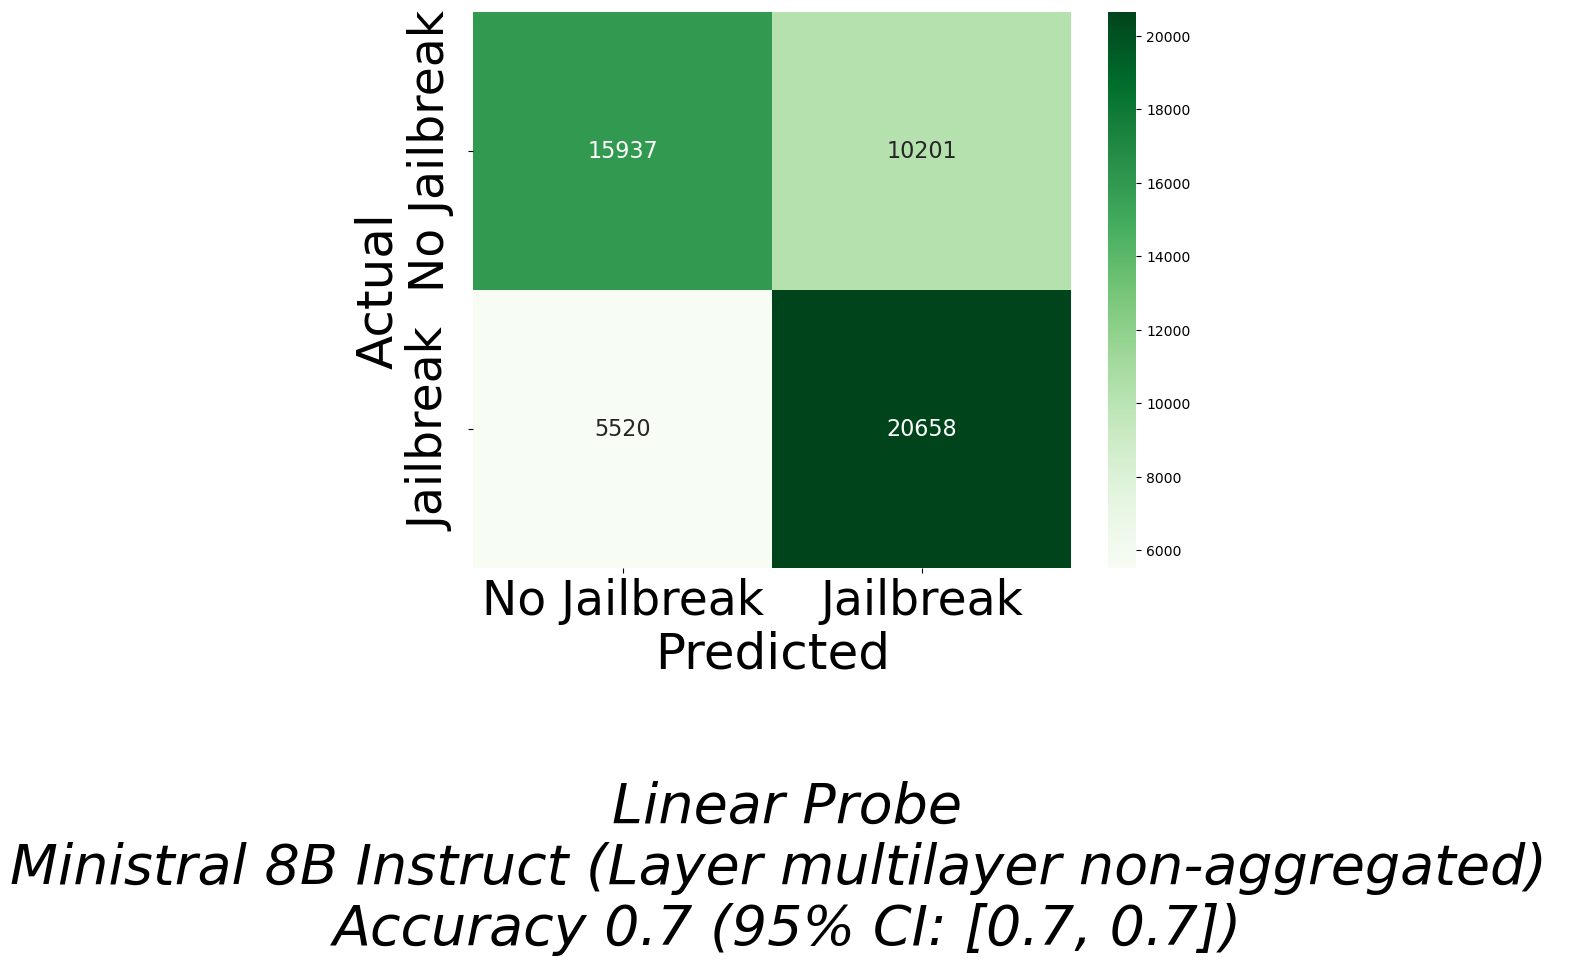

In [18]:
## LINEAR PROBE

save_path = IMAGES_DIR / f"{publication}/confusion_matrices/{model_name}/{model_name}_multilayer_aggregated_linear_probe.pdf"

log_model, train_accuracy, accuracy= create_logistic_regression_model(train_data, train_labels, test_data, test_labels)

multilayer_linear_accuracy_non_aggregated = round(accuracy,2)
print(multilayer_linear_accuracy_non_aggregated)

conf_matrix_log, accuracy_linear_non_aggregated = get_confusion_matrix_and_accuracy(log_model = log_model, X_test = test_data, y_test = test_labels)

lower_bound, upper_bound = get_confidence_interval(accuracy, len(test_labels))

lower_bound = round(lower_bound, 2)
upper_bound = round(upper_bound, 2) 


multilayer_linear_ci_non_aggregated = (lower_bound, upper_bound)
  
print(f'95% Confidence Interval: {lower_bound} - {upper_bound}')

# plot
plot_confusion_matrix(conf_matrix = conf_matrix_log, accuracy = f"{ accuracy_linear_non_aggregated} (95% CI: [{lower_bound}, {upper_bound}])", probe_type = "Linear", dataset_name= "", model_name = model_name, layer = layer_nr, class_names= df["rating_binary"].unique(), savepath = save_path)


# save
save_probe_results(
    publication=publication,
    model_name=model_name,
    probe_type="linear",
    accuracy=accuracy_linear_non_aggregated,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    conf_matrix=conf_matrix_log,
    save_path=save_path, 
    layer_nr=layer_nr
)




/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6434
Epoch [20/500], Loss: 0.6073
Epoch [30/500], Loss: 0.5815
Epoch [40/500], Loss: 0.5608
Epoch [50/500], Loss: 0.5434
Epoch [60/500], Loss: 0.5286
Epoch [70/500], Loss: 0.5157
Epoch [80/500], Loss: 0.5046
Epoch [90/500], Loss: 0.4947
Epoch [100/500], Loss: 0.4859
Epoch [110/500], Loss: 0.4781
Epoch [120/500], Loss: 0.4711
Epoch [130/500], Loss: 0.4648
Epoch [140/500], Loss: 0.4590
Epoch [150/500], Loss: 0.4537
Epoch [160/500], Loss: 0.4489
Epoch [170/500], Loss: 0.4444
Epoch [180/500], Loss: 0.4403
Epoch [190/500], Loss: 0.4365
Epoch [200/500], Loss: 0.4329
Epoch [210/500], Loss: 0.4295
Epoch [220/500], Loss: 0.4263
Epoch [230/500], Loss: 0.4233
Epoch [240/500], Loss: 0.4205
Epoch [250/500], Loss: 0.4179
Epoch [260/500], Loss: 0.4153
Epoch [270/500], Loss: 0.4130
Epoch [280/500], Loss: 0.4107
Epoch [290/500], Loss: 0.4085
Epoch [300/500], Loss: 0.4064
Epoch [310/500], Loss: 0.4044
Epoch [320/500], Loss: 0.4025
Epoch [330/500], Loss: 0.4007
Epoch [340/500], Lo

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)


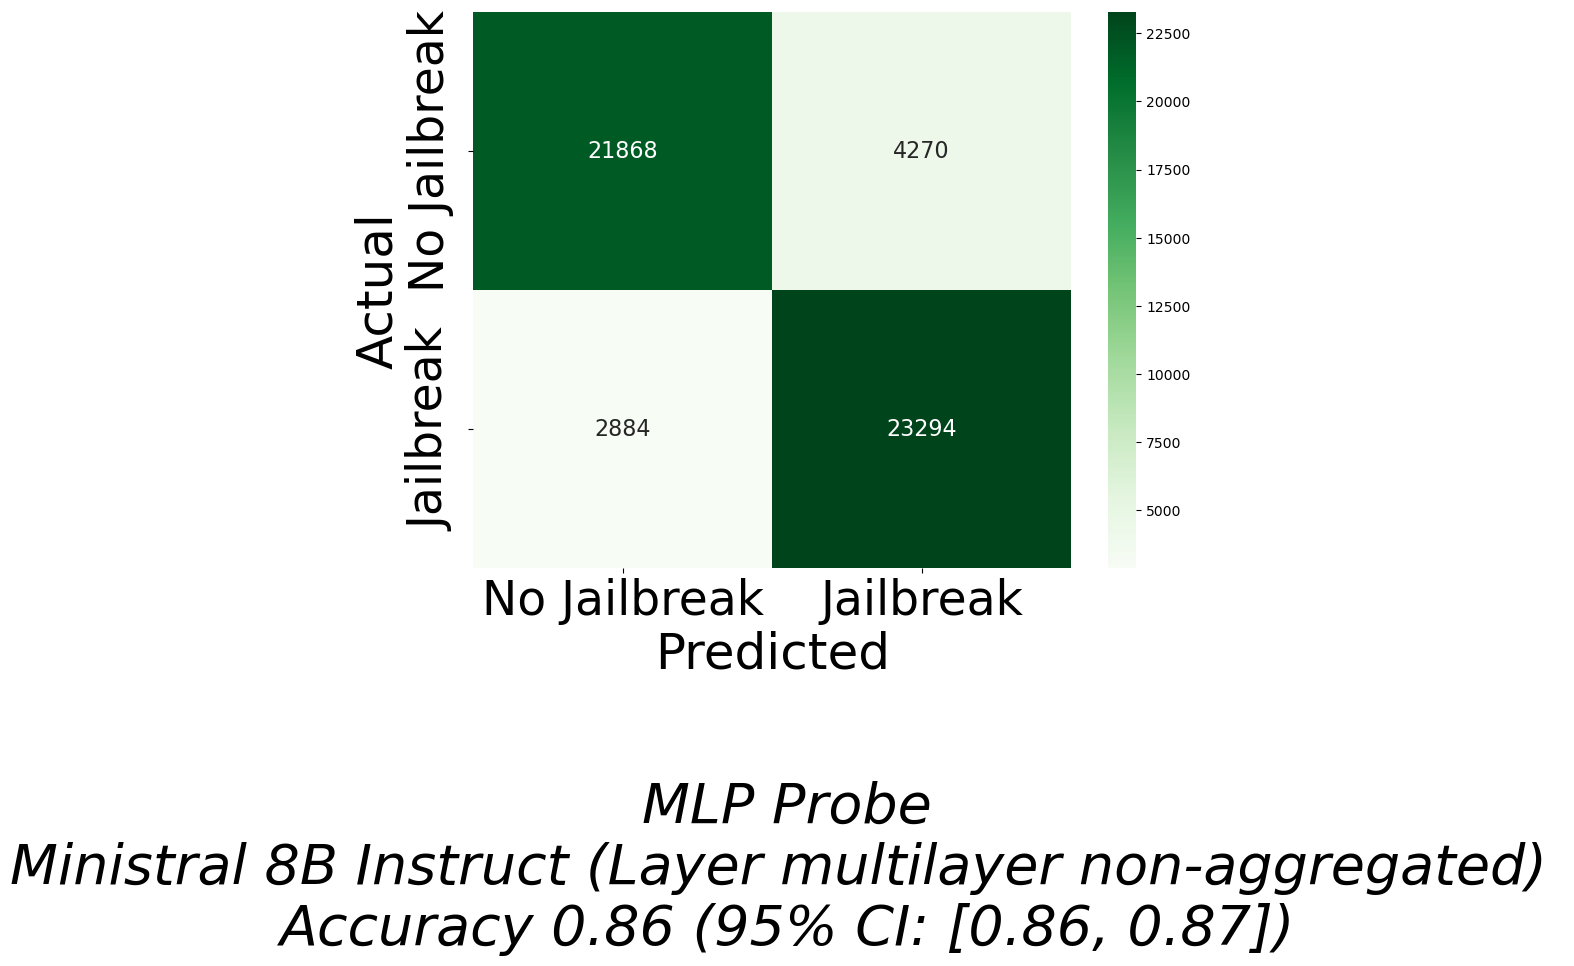

In [19]:
save_path = IMAGES_DIR / f"{publication}/confusion_matrices/{model_name}/{model_name}_multilayer_non_aggregated_mlp_probe.pdf"


mlp = SimpleMLP(input_size=input_size)

mlp.to("cuda")


mlp.train_MLP(train_data = train_data, train_labels = train_labels, num_epochs = 500)
accuracy, conf_matrix = mlp.get_accuracy(test_data = test_data, test_labels = test_labels)


# Get foncidence interval
lower_bound, upper_bound = get_confidence_interval(accuracy, len(test_labels))

multilayer_mlp_accuracy_non_aggregated = round(accuracy, 2)
multilayer_mlp_lower_bound_non_aggregated = round(lower_bound, 2)
multilayer_mlp_upper_bound_non_aggregated = round(upper_bound, 2)

multilayer_mlp_ci_non_aggregated = (multilayer_mlp_lower_bound_non_aggregated, multilayer_mlp_upper_bound_non_aggregated)

# plot
plot_confusion_matrix(conf_matrix = conf_matrix, accuracy = f"{multilayer_mlp_accuracy_non_aggregated} (95% CI: [{multilayer_mlp_lower_bound_non_aggregated}, {multilayer_mlp_upper_bound_non_aggregated}])", probe_type = "MLP", dataset_name= "", model_name = model_name, layer = layer_nr, class_names= df["rating_binary"].unique(), savepath = save_path )


# save
save_probe_results(
    publication=publication,
    model_name=model_name,
    probe_type="mlp",
    accuracy=multilayer_mlp_accuracy_non_aggregated,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    conf_matrix=conf_matrix,
    save_path=save_path, 
    layer_nr=layer_nr
)



In [20]:
# TRANSFORMER PROBE
save_path = IMAGES_DIR / f"{publication}/confusion_matrices/{model_name}/{model_name}_multilayer_non_aggregated_transformer_probe.pdf"

torch.cuda.set_device(0)  # Ensure using first GPU
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # For synchronous error reporting


trans_probe = TransformerProbe(input_size=input_size)
trans_probe.to("cuda")

trans_probe.train_probe(train_data = train_data, train_labels = train_labels, num_epochs = 500)
accuracy, conf_matrix = trans_probe.get_accuracy(test_data = test_data, test_labels = test_labels)

# Get foncidence interval
lower_bound, upper_bound = get_confidence_interval(accuracy, len(test_labels))

multilayer_trans_accuracy_non_aggregated = round(accuracy, 2)
multilayer_trans_lower_bound_non_aggregated = round(lower_bound, 2)
multilayer_trans_upper_bound_non_aggregated = round(upper_bound, 2)

multilayer_trans_ci_non_aggregated = (multilayer_trans_lower_bound_non_aggregated, multilayer_trans_upper_bound_non_aggregated)


# plot
plot_confusion_matrix(conf_matrix = conf_matrix, accuracy = f"{multilayer_trans_accuracy_non_aggregated} (95% CI: [{multilayer_trans_lower_bound_non_aggregated}, {multilayer_trans_upper_bound_non_aggregated}])", probe_type = "Transformer", dataset_name= "", model_name = model_name, layer = layer_nr, class_names= df["rating_binary"].unique(), savepath = save_path )


# save
save_probe_results(
    publication=publication,
    model_name=model_name,
    probe_type="transformer",
    accuracy=multilayer_trans_accuracy_non_aggregated, 
    lower_bound=multilayer_trans_lower_bound_non_aggregated,
    upper_bound=multilayer_trans_upper_bound_non_aggregated,
    conf_matrix=conf_matrix,
    save_path=save_path, 
    layer_nr=layer_nr
)


Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


Error during training!
X_train device: cuda:0
Model device: cuda:0
Batch size: 209260


RuntimeError: CUDA error: invalid configuration argument
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [74]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Train Probes with aggregated data

In [25]:
# Calculate the layers of interest
layers = range(0, num_layers)
  
if "gemma" in model_name: 
    def extract_layer(row, layer, activation_column="prompt_res_activations"):
        activation = row[activation_column][layer][0]
        # Average across the first dimension (4 heads) instead of flattening
        return activation.mean(dim=0).cpu().numpy()  # This will give a (3072,) array


    # Test with one sample
    sample_activation = df.iloc[0][activation_column][0][0]
    print(f"Sample activation tensor shape: {sample_activation.shape}")

    train_data, train_labels, test_data, test_labels = get_data_and_labels_multilayer_aggregate_new(df = df , layers = layers, split_idx = 0.8)

else: 
    train_data, train_labels, test_data, test_labels = get_data_and_labels_multilayer_aggregate(df = df , layers = layers, split_idx = 0.8) 

Sample activation tensor shape: torch.Size([4, 3072])
First layer shape: 3072
layer_features shape: (28, 1168, 3072)
transposed shape: (1168, 28, 3072)
final data shape: (1168, 3072)


0.77
95% Confidence Interval: 0.72 - 0.83


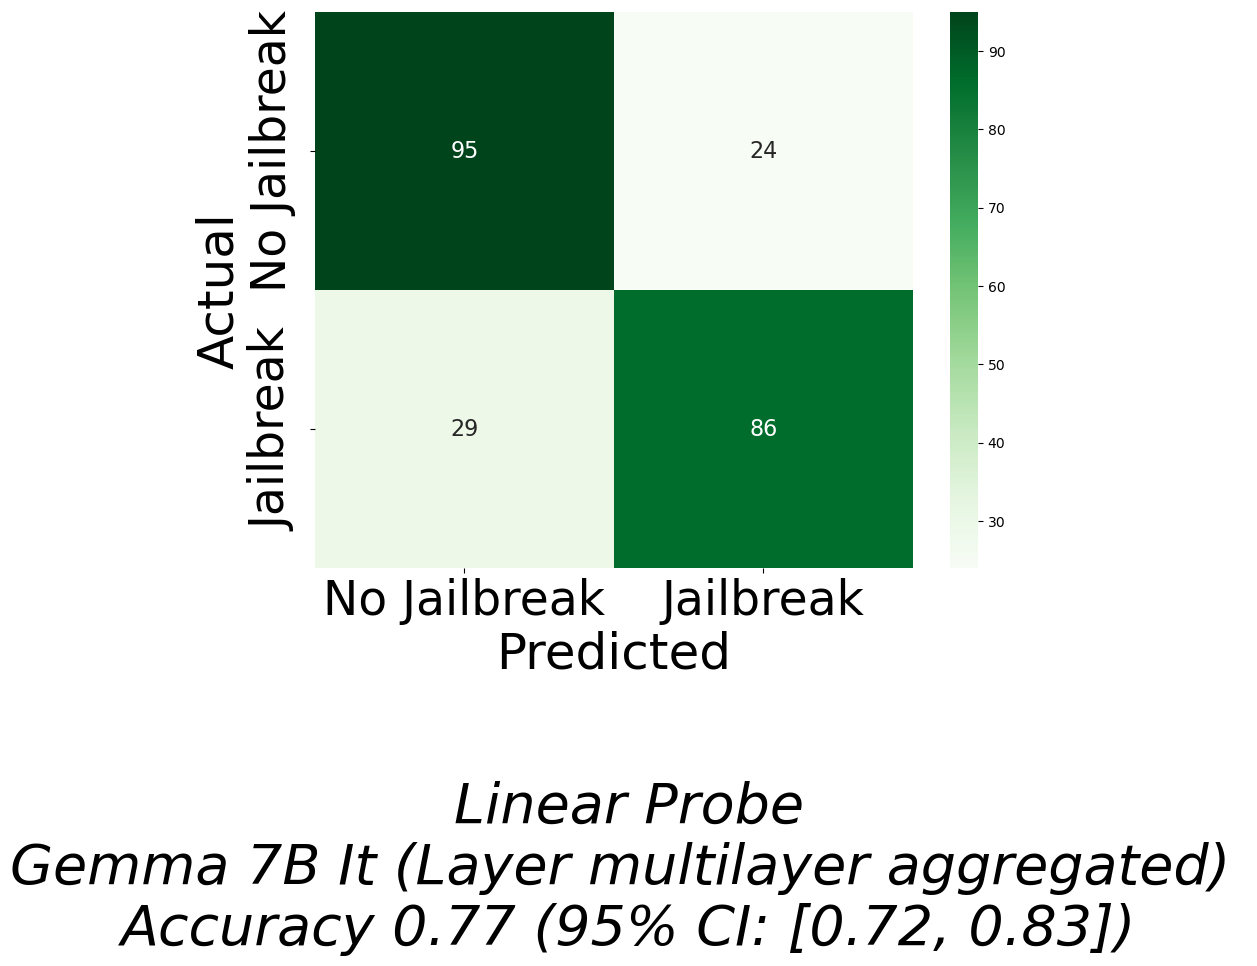

In [ ]:
## LINEAR PROBE

log_model, train_accuracy, accuracy= create_logistic_regression_model(train_data, train_labels, test_data, test_labels)

multilayer_linear_accuracy_aggregated = round(accuracy,2)
print(multilayer_linear_accuracy_aggregated)

conf_matrix_log, accuracy_linear_aggregated = get_confusion_matrix_and_accuracy(log_model = log_model, X_test = test_data, y_test = test_labels)

lower_bound, upper_bound = get_confidence_interval(accuracy, len(test_labels))

lower_bound = round(lower_bound, 2)
upper_bound = round(upper_bound, 2) 


multilayer_linear_ci_aggregated = (lower_bound, upper_bound)
  
print(f'95% Confidence Interval: {lower_bound} - {upper_bound}')

save_path = IMAGES_DIR / f"{publication}/confusion_matrices/{model_name}/{model_name}_multilayer_aggregated_linear_probe.pdf"

layer_nr = "multilayer aggregated"

plot_confusion_matrix(conf_matrix = conf_matrix_log, accuracy = f"{ accuracy_linear_aggregated} (95% CI: [{lower_bound}, {upper_bound}])", probe_type = "Linear", dataset_name= "", model_name = model_name, layer = layer_nr, class_names= df["rating_binary"].unique(), savepath = save_path)


# save probe
path = DATASETS_DIR / f"{publication}/Probes/{model_name}/linear/{model_name}_{layer_nr}_linear_probe_acc{accuracy}.pkl"
path.parent.mkdir(parents=True, exist_ok=True)
# Save the model
with open(path, 'wb') as file:
    pickle.dump(log_model, file)



# save
save_probe_results(
    publication=publication,
    model_name=model_name,
    probe_type="linear",
    accuracy=accuracy,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    conf_matrix=conf_matrix_log,
    save_path=save_path, 
    layer_nr=layer_nr
)




In [27]:
accuracy

0.7735042735042735

In [ ]:
mlp = SimpleMLP(input_size=input_size)

mlp.to("cpu")


mlp.train_MLP(train_data = train_data, train_labels = train_labels, num_epochs = 500)
accuracy, conf_matrix = mlp.get_accuracy(test_data = test_data, test_labels = test_labels)


# Get foncidence interval
lower_bound, upper_bound = get_confidence_interval(accuracy, len(test_labels))

multilayer_mlp_accuracy_aggregated = round(accuracy, 2)
multilayer_mlp_lower_bound_aggregated = round(lower_bound, 2)
multilayer_mlp_upper_bound_aggregated = round(upper_bound, 2)

multilayer_mlp_ci_aggregated = (multilayer_mlp_lower_bound_aggregated, multilayer_mlp_upper_bound_aggregated)


save_path = IMAGES_DIR / f"{publication}/confusion_matrices/{model_name}/{model_name}_multilayer_aggregated_mlp_probe.pdf"

plot_confusion_matrix(conf_matrix = conf_matrix, accuracy = f"{multilayer_mlp_accuracy_aggregated} (95% CI: [{multilayer_mlp_lower_bound_aggregated}, {multilayer_mlp_upper_bound_aggregated}])", probe_type = "MLP", dataset_name= "", model_name = model_name, layer = layer_nr, class_names= df["rating_binary"].unique(), savepath = save_path )


# save probe 
path = DATASETS_DIR / f"{publication}/Probes/{model_name}/mlp/{model_name}_{layer_nr}_mlp_probe_acc{accuracy}.th"
path.parent.mkdir(parents=True, exist_ok=True)
mlp.save_probe(path)

save_probe_results(
    publication=publication,
    model_name=model_name,
    probe_type="mlp",
    accuracy=accuracy,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    conf_matrix=conf_matrix_log,
    save_path=save_path, 
    layer_nr=layer_nr
)


Epoch [10/500], Loss: 0.6316
Epoch [20/500], Loss: 0.5971
Epoch [30/500], Loss: 0.5758
Epoch [40/500], Loss: 0.5601
Epoch [50/500], Loss: 0.5474
Epoch [60/500], Loss: 0.5368
Epoch [70/500], Loss: 0.5274
Epoch [80/500], Loss: 0.5191
Epoch [90/500], Loss: 0.5115
Epoch [100/500], Loss: 0.5045
Epoch [110/500], Loss: 0.4980
Epoch [120/500], Loss: 0.4920
Epoch [130/500], Loss: 0.4863
Epoch [140/500], Loss: 0.4810
Epoch [150/500], Loss: 0.4760
Epoch [160/500], Loss: 0.4713
Epoch [170/500], Loss: 0.4668
Epoch [180/500], Loss: 0.4625
Epoch [190/500], Loss: 0.4584
Epoch [200/500], Loss: 0.4543
Epoch [210/500], Loss: 0.4503
Epoch [220/500], Loss: 0.4466
Epoch [230/500], Loss: 0.4430
Epoch [240/500], Loss: 0.4397
Epoch [250/500], Loss: 0.4364
Epoch [260/500], Loss: 0.4333
Epoch [270/500], Loss: 0.4303
Epoch [280/500], Loss: 0.4274
Epoch [290/500], Loss: 0.4246
Epoch [300/500], Loss: 0.4219
Epoch [310/500], Loss: 0.4193
Epoch [320/500], Loss: 0.4168
Epoch [330/500], Loss: 0.4143
Epoch [340/500], Lo

KeyboardInterrupt: 

Dimensions: input_size=3072, d_model=512, seq_len=8, nhead=8
Epoch [10/500], Loss: 0.5395, Accuracy: 0.7963
Epoch [20/500], Loss: 0.2761, Accuracy: 0.8939
Epoch [30/500], Loss: 0.1745, Accuracy: 0.9159
Epoch [40/500], Loss: 0.1221, Accuracy: 0.9463
Epoch [50/500], Loss: 0.0885, Accuracy: 0.9561
Epoch [60/500], Loss: 0.1212, Accuracy: 0.9488
Epoch [70/500], Loss: 0.0855, Accuracy: 0.9561
Epoch [80/500], Loss: 0.1430, Accuracy: 0.9439
Epoch [90/500], Loss: 0.1187, Accuracy: 0.9512
Epoch [100/500], Loss: 0.1228, Accuracy: 0.9524
Epoch [110/500], Loss: 0.0939, Accuracy: 0.9463
Epoch [120/500], Loss: 0.0834, Accuracy: 0.9561
Epoch [130/500], Loss: 0.0743, Accuracy: 0.9646
Epoch [140/500], Loss: 0.0834, Accuracy: 0.9622
Epoch [150/500], Loss: 0.0855, Accuracy: 0.9585
Epoch [160/500], Loss: 0.0677, Accuracy: 0.9598
Epoch [170/500], Loss: 0.0638, Accuracy: 0.9732
Epoch [180/500], Loss: 0.0885, Accuracy: 0.9512
Epoch [190/500], Loss: 0.0816, Accuracy: 0.9500
Epoch [200/500], Loss: 0.0743, Accur

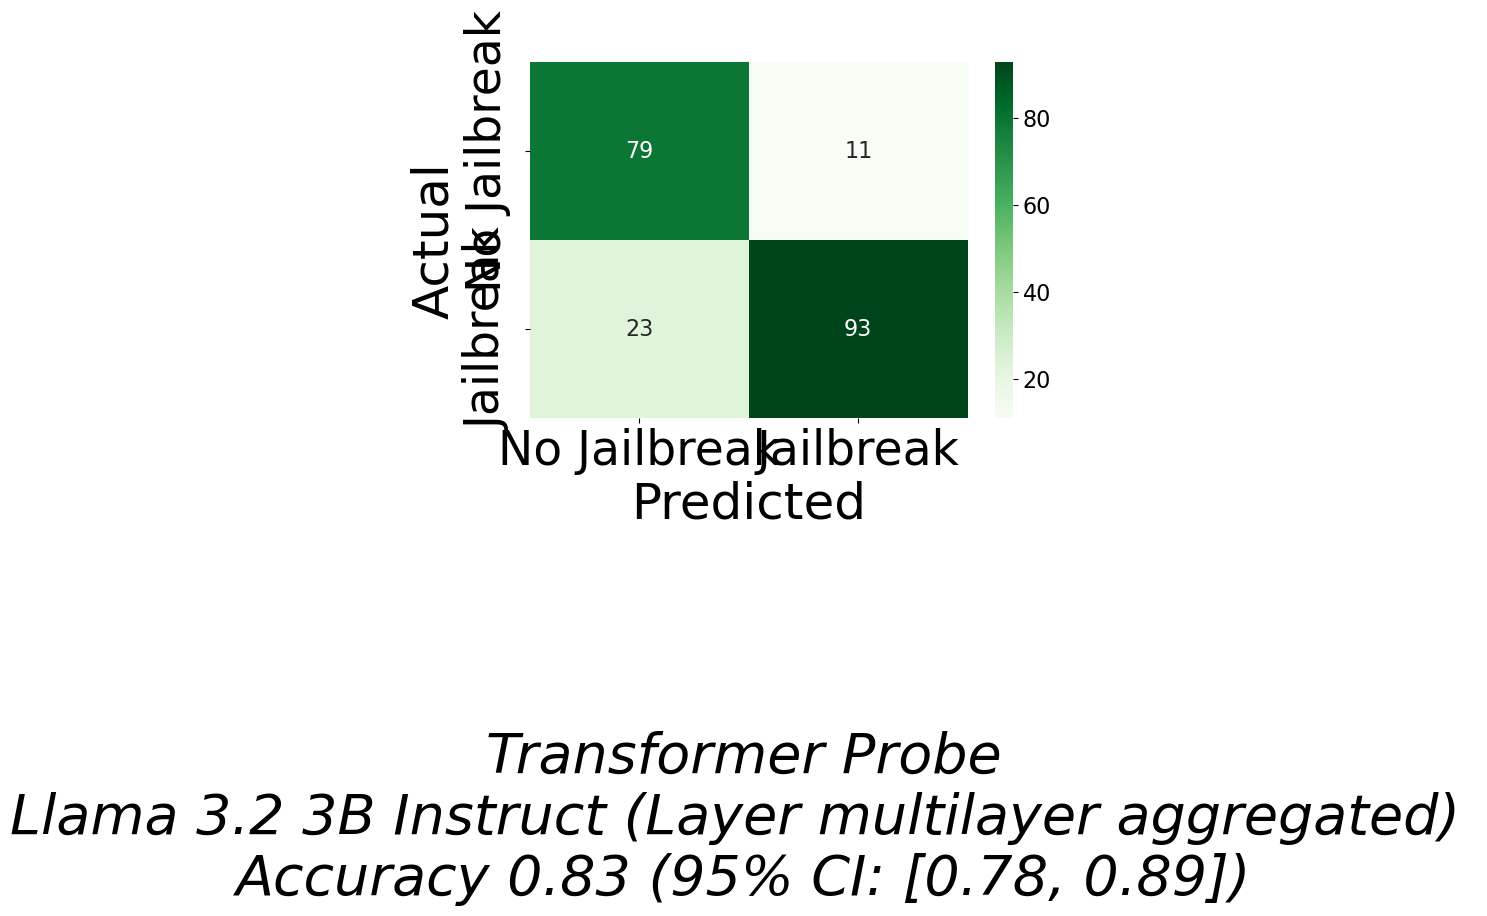

Model saved to /data/nathalie_maria_kirch/ERA_Fellowship/datasets/public_2/Probes/Llama-3.2-3B-Instruct/transformer/Llama-3.2-3B-Instruct_multilayer aggregated_transformer_acc0.8349514563106796.pth


In [47]:
# TRANSFORMER PROBE

trans_probe = TransformerProbe(input_size=input_size)
trans_probe.to("cuda")

trans_probe.train_probe(train_data = train_data, train_labels = train_labels, num_epochs = 500)
accuracy, conf_matrix = trans_probe.get_accuracy(test_data = test_data, test_labels = test_labels)

# Get foncidence interval
lower_bound, upper_bound = get_confidence_interval(accuracy, len(test_labels))

multilayer_trans_accuracy_aggregated = round(accuracy, 2)
multilayer_trans_lower_bound_aggregated = round(lower_bound, 2)
multilayer_trans_upper_bound_aggregated = round(upper_bound, 2)

multilayer_trans_ci_aggregated = (multilayer_trans_lower_bound_aggregated, multilayer_trans_upper_bound_aggregated)

save_path = IMAGES_DIR / f"{publication}/confusion_matrices/{model_name}/{model_name}_multilayer_aggregated_transformer_probe.pdf"

plot_confusion_matrix(conf_matrix = conf_matrix, accuracy = f"{multilayer_trans_accuracy_aggregated} (95% CI: [{multilayer_trans_lower_bound_aggregated}, {multilayer_trans_upper_bound_aggregated}])", probe_type = "Transformer", dataset_name= "", model_name = model_name, layer = layer_nr, class_names= df["rating_binary"].unique(), savepath = save_path )

# save probe
path = DATASETS_DIR / f"{publication}/Probes/{model_name}/transformer/{model_name}_{layer_nr}_transformer_acc{accuracy}"
path.parent.mkdir(parents=True, exist_ok=True)

trans_probe.save_probe(path)


save_probe_results(
    publication=publication,
    model_name=model_name,
    probe_type="transformer",
    accuracy=accuracy,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    conf_matrix=conf_matrix_log,
    save_path=save_path, 
    layer_nr=layer_nr
)




# Train single-layer probes

In [30]:
layers = range(1, num_layers)


split_idx = int(0.8* len(df))
labels = df["rating_binary"].to_list()
train_labels = labels[:split_idx]
test_labels = labels[split_idx:]


linear_accuracies = []
linear_ci = []

mlp_accuracies = []
mlp_ci = []

transformer_accuracies = []
transformer_ci = []

for layer in layers: 
  print(f"--layer {layer}")
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
  

  data = df[f'layer_{layer}'].to_list()
  
  train_data = data[:split_idx]
  test_data = data[split_idx:]
  
  ### LINEAR PROBE
  _, _, linear_accuracy= create_logistic_regression_model(train_data, train_labels, test_data, test_labels)
  lower_bound, upper_bound = get_confidence_interval(linear_accuracy, len(test_labels))
  linear_accuracies.append(linear_accuracy)
  linear_ci.append((lower_bound, upper_bound))

  # save single layer accuracies 
  save_probe_results(
    publication=publication,
    model_name=model_name,
    probe_type="linear",
    accuracy=linear_accuracy,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    layer_nr=layer
  )
  
  
  ### MLP PROBE
  mlp = SimpleMLP(input_size=input_size)

  mlp.to("cuda")

  mlp.train_MLP(train_data = train_data, train_labels = train_labels, num_epochs = 500)
  mlp_accuracy, _ = mlp.get_accuracy(test_data = test_data, test_labels = test_labels)
  lower_bound, upper_bound = get_confidence_interval(mlp_accuracy, len(test_labels))

  mlp_accuracies.append(round(mlp_accuracy, 2))
  mlp_ci.append((round(lower_bound,2), round(upper_bound, 2))) 
      # save single layer accuracies 
  save_probe_results(
    publication=publication,
    model_name=model_name,
    probe_type="mlp",
    accuracy=mlp_accuracy,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    layer_nr=layer
  )

  ### TRANSFORMER PROBE
  transformer = TransformerProbe(input_size=input_size)
  transformer.to("cuda")
  
  transformer.train_probe(train_data = train_data, train_labels = train_labels, num_epochs = 500)
  transformer_accuracy, _ = transformer.get_accuracy(test_data = test_data, test_labels = test_labels)
  lower_bound, upper_bound = get_confidence_interval(transformer_accuracy, len(test_labels))
  
  transformer_accuracies.append(round(transformer_accuracy, 2))
  transformer_ci.append((round(lower_bound, 2), round(upper_bound, 2)))

  # save single layer accuracies 
  save_probe_results(
    publication=publication,
    model_name=model_name,
    probe_type="transformer",
    accuracy=mlp_accuracy,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    layer_nr=layer
  ) 

  
  if layer == len(layers) // 2: 
    # save probe
    path = DATASETS_DIR / f"{publication}/Probes/{model_name}/linear/{model_name}_{layer}_linear_probe_acc{accuracy}.pkl"
    # Save the model
    with open(path, 'wb') as file:
        pickle.dump(log_model, file)
    
    mlp.save_probe(DATASETS_DIR / f"{publication}/Probes/{model_name}/mlp/{model_name}_{layer}_mlp_probe_acc{mlp_accuracy}.th")
    transformer.save_probe(DATASETS_DIR / f"{publication}/Probes/{model_name}/transformer/{model_name}_{layer}_transformer_acc{transformer_accuracy}")
    



--layer 1
Epoch [10/500], Loss: 0.6103
Epoch [20/500], Loss: 0.5774
Epoch [30/500], Loss: 0.5572
Epoch [40/500], Loss: 0.5434
Epoch [50/500], Loss: 0.5324
Epoch [60/500], Loss: 0.5247
Epoch [70/500], Loss: 0.5188
Epoch [80/500], Loss: 0.5139
Epoch [90/500], Loss: 0.5095
Epoch [100/500], Loss: 0.5056
Epoch [110/500], Loss: 0.5020
Epoch [120/500], Loss: 0.4985
Epoch [130/500], Loss: 0.4952
Epoch [140/500], Loss: 0.4920
Epoch [150/500], Loss: 0.4890
Epoch [160/500], Loss: 0.4862
Epoch [170/500], Loss: 0.4833
Epoch [180/500], Loss: 0.4805
Epoch [190/500], Loss: 0.4778
Epoch [200/500], Loss: 0.4750
Epoch [210/500], Loss: 0.4723
Epoch [220/500], Loss: 0.4697
Epoch [230/500], Loss: 0.4671
Epoch [240/500], Loss: 0.4645
Epoch [250/500], Loss: 0.4619
Epoch [260/500], Loss: 0.4592
Epoch [270/500], Loss: 0.4566
Epoch [280/500], Loss: 0.4538
Epoch [290/500], Loss: 0.4510
Epoch [300/500], Loss: 0.4482
Epoch [310/500], Loss: 0.4451
Epoch [320/500], Loss: 0.4418
Epoch [330/500], Loss: 0.4380
Epoch [34

In [31]:
print(len(linear_accuracies), len(mlp_accuracies), len(transformer_accuracies))
print(len(linear_ci), len(mlp_ci), len(transformer_ci))

27 27 27
27 27 27


# Plot

In [29]:
# Import the init_paths module
from init_paths import (
    PROJECT_ROOT,
    DATASETS_DIR,
    ANALYSIS_DIR,
    EXPERIMENTS_DIR,
    IMAGES_DIR,
    GEN_DATA_DIR,
    LOGS_DIR,
    get_project_path
)

In [63]:
import pandas as pd
from pathlib import Path
import os
from analysis.models import get_model_details
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from pathlib import Path

publication = ["public_1", "public_2"][1]
model_name = ["gemma-7b-it", "Llama-3.1-8B-Instruct", "Llama-3.2-3B-Instruct", "Ministral-8B-Instruct"][3]
model_name, num_layers, rating_column, hf_ident, input_size = get_model_details(model_name)
layers = range(1, num_layers)


# get data from csv
probe_data = pd.read_csv(DATASETS_DIR / f"{publication}/{model_name}/{model_name}_probe_accuracies.csv")

save_path = IMAGES_DIR / f"{publication}/accuracy_by_layer/{model_name}/{model_name}_probe_comparison_layerwise_multilayer_aggregated_probes_plot.pdf"
probe_data

,type of probe,layer_nr,accuracy,lower_bound,upper_bound,conf_matrix,probe_path
0,linear,multilayer aggregated,0.905777,0.890000,0.920000,[[632; 87];\n [ 50;685]],/data/nathalie_maria_kirch/ERA_Fellowship/imag...
1,mlp,multilayer aggregated,0.843191,0.824501,0.861882,[[632; 87];\n [ 50;685]],/data/nathalie_maria_kirch/ERA_Fellowship/imag...
2,transformer,multilayer aggregated,0.897524,0.881935,0.913113,[[632; 87];\n [ 50;685]],/data/nathalie_maria_kirch/ERA_Fellowship/imag...
3,linear,1,0.803301,0.782869,0.823733,NaN,NaN
4,mlp,1,0.846630,0.828108,0.865152,NaN,NaN
...,...,...,...,...,...,...,...
106,transformer,13,0.877579,0.887815,0.918237,NaN,NaN
107,linear,14,0.892710,0.876802,0.908618,NaN,NaN
108,mlp,14,0.882393,0.865835,0.898952,NaN,NaN
109,linear,multilayer non-aggregated,0.700000,0.700000,0.700000,[[15937;10201];\n [ 5520;20658]],/data/nathalie_maria_kirch/ERA_Fellowship/imag...


In [64]:
# get probe data with type of probe = mlp and layer_nr = multilayer non-aggregated
mlp_multilayer_non_aggregated = probe_data[(probe_data["type of probe"] == "mlp") & (probe_data["layer_nr"] == "multilayer non-aggregated")]
mlp_multilayer_non_aggregated



,type of probe,layer_nr,accuracy,lower_bound,upper_bound,conf_matrix,probe_path


In [65]:
probe_data.columns

Index(['type of probe', 'layer_nr', 'accuracy', 'lower_bound', 'upper_bound',
       'conf_matrix', 'probe_path'],
      dtype='object')

In [66]:
# Update the plot_probe_comparison_split function to handle mismatched dimensions
def plot_probe_comparison_split_fixed(layers, probe_data, model_name="", save_path=None):
    """
    Plot comparison of probe accuracies with fixed y-axis from 50% to 100%.
    With added handling for mismatched dimensions.
    """
    
    # Increase all font sizes
    plt.rcParams.update({
        'font.size': 16,
        'axes.titlesize': 20,
        'axes.labelsize': 18,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 16
    })

    # Create figure for main plot
    fig_plot = plt.figure(figsize=(10, 7))
    ax_plot = fig_plot.add_subplot(111)
    
    # Create separate figure for legend
    fig_legend = plt.figure(figsize=(4, 2.5))
    ax_legend = fig_legend.add_subplot(111)
    ax_legend.set_axis_off()
    
    # Style parameters with thicker lines
    STYLE_PARAMS = {
        'layer-wise': {
            'linewidth': 3.5,
            'linestyle': '-'
        },
        'multilayer': {
            'linewidth': 3.5,
            'linestyle': '--'
        }
    }
    
    # Function to convert accuracies to percentages
    def to_percent(value):
        return value * 100 if isinstance(value, (int, float)) else [v * 100 for v in value]
    
    # Fixed vertical offset for multilayer lines
    vertical_offset = 0.2  # Small offset for overlapping lines
    
    # Calculate x-axis offset for confidence intervals
    x_range = list(layers)
    x_range_size = max(x_range) - min(x_range)
    horizontal_offset = x_range_size * 0.01  # Offset between CI lines
    
    legend_handles = []
    legend_labels = []
    
    # First plot layer-wise probes
    for probe_name, probe_info in probe_data.items():
        if probe_info['type'] == 'layer-wise':
            style = STYLE_PARAMS[probe_info['type']]
            color = probe_info['color']
            
            # Ensure x and y have same dimensions
            y_values = to_percent(probe_info['accuracies'])
            
            # Create matching x values based on the length of y_values
            # If y_values is shorter than layers, we'll use only a subset of layers
            if len(y_values) < len(layers):
                print(f"Warning: {probe_name} has fewer data points ({len(y_values)}) than layers ({len(layers)})")
                # Use the first len(y_values) layers
                x_values = list(layers)[:len(y_values)]
            else:
                # Make sure we don't use more data points than we have layers
                x_values = list(layers)
                y_values = y_values[:len(x_values)]  # Trim y to match x length
            
            # Debug output
            print(f"Probe: {probe_name}, x_shape: {len(x_values)}, y_shape: {len(y_values)}")
            
            ax_plot.plot(x_values, y_values,
                        color=color,
                        linestyle=style['linestyle'],
                        linewidth=style['linewidth'])
            
            legend_line = mlines.Line2D([], [], 
                                      color=color,
                                      linestyle=style['linestyle'],
                                      linewidth=style['linewidth'],
                                      label=probe_name)
            
            legend_handles.append(legend_line)
            legend_labels.append(probe_name)
    
    # Then plot multilayer probes
    multilayer_count = 0
    ci_line_width = 2.0
    
    for probe_name, probe_info in probe_data.items():
        if probe_info['type'] == 'multilayer':
            style = STYLE_PARAMS[probe_info['type']]
            color = probe_info['color']
            
            # Check if there's any data to plot
            if not probe_info['accuracies'] and isinstance(probe_info['accuracies'], list):
                print(f"Warning: No accuracy data for {probe_name}, skipping plot")
                continue
                
            # Convert values to percentages and add vertical offset
            if isinstance(probe_info['accuracies'], list):
                # Print debug info to help diagnose the issue
                print(f"Multilayer probe: {probe_name}, accuracies: {probe_info['accuracies']}")
                if probe_info['accuracies']:
                    accuracy = probe_info['accuracies'][0]
                else:
                    print(f"Warning: Empty accuracies list for {probe_name}, skipping plot")
                    continue
            else:
                accuracy = probe_info['accuracies']
                
            adjusted_value = to_percent(accuracy) + (vertical_offset * multilayer_count)
            
            # Debug output for CIs
            print(f"Multilayer probe: {probe_name}, CIs: {probe_info['cis']}")
            
            # Default CI values in case data is missing
            default_ci_low = adjusted_value - 2  # default CI of 2%
            default_ci_high = adjusted_value + 2
            
            if isinstance(probe_info['cis'], list) and len(probe_info['cis']) >= 2:
                if isinstance(probe_info['cis'][0], list):
                    if probe_info['cis'][0] and probe_info['cis'][1]:
                        adjusted_ci_low = to_percent(probe_info['cis'][0][0]) + (vertical_offset * multilayer_count)
                        adjusted_ci_high = to_percent(probe_info['cis'][1][0]) + (vertical_offset * multilayer_count)
                    else:
                        print(f"Warning: Empty CI lists for {probe_name}, using default CI values")
                        adjusted_ci_low = default_ci_low
                        adjusted_ci_high = default_ci_high
                else:
                    adjusted_ci_low = to_percent(probe_info['cis'][0]) + (vertical_offset * multilayer_count)
                    adjusted_ci_high = to_percent(probe_info['cis'][1]) + (vertical_offset * multilayer_count)
            else:
                # If CIs are missing or malformed, set default values
                print(f"Warning: CI data for {probe_name} is missing or malformed, using default CI values")
                adjusted_ci_low = default_ci_low
                adjusted_ci_high = default_ci_high
            
            # Calculate x-position for confidence interval
            x_ci = min(x_range) + (horizontal_offset * multilayer_count)
            
            # Plot horizontal line
            ax_plot.plot([min(x_range), max(x_range)], 
                        [adjusted_value, adjusted_value],
                        color=color,
                        linestyle=style['linestyle'],
                        linewidth=style['linewidth'])
            
            # Plot confidence interval
            ax_plot.plot([x_ci, x_ci],
                        [adjusted_ci_low, adjusted_ci_high],
                        color=color,
                        linewidth=ci_line_width,
                        solid_capstyle='butt')
            
            # Add caps to confidence interval
            cap_width = horizontal_offset * 0.5
            ax_plot.plot([x_ci - cap_width, x_ci + cap_width],
                        [adjusted_ci_low, adjusted_ci_low],
                        color=color,
                        linewidth=ci_line_width,
                        solid_capstyle='butt')
            ax_plot.plot([x_ci - cap_width, x_ci + cap_width],
                        [adjusted_ci_high, adjusted_ci_high],
                        color=color,
                        linewidth=ci_line_width,
                        solid_capstyle='butt')
            
            legend_line = mlines.Line2D([], [],
                                      color=color,
                                      linestyle=style['linestyle'],
                                      linewidth=style['linewidth'],
                                      label=probe_name)
            
            legend_handles.append(legend_line)
            legend_labels.append(probe_name)
            
            multilayer_count += 1
    
    # Random chance line
    ax_plot.plot([min(x_range), max(x_range)], [50, 50],
                 color='gray', linestyle=':', alpha=0.5, linewidth=2.5)
    
    legend_random = mlines.Line2D([], [], color='gray', linestyle=':',
                                alpha=0.5, linewidth=2.5, label='Random Chance')
    legend_handles.append(legend_random)
    legend_labels.append('Random Chance')
    
    # Customize plot
    ax_plot.set_xlabel('Layer', labelpad=12)
    ax_plot.set_ylabel('Accuracy (%)', labelpad=12)
    
    # Format model name
    formatted_model_name = model_name.replace('-', ' ').title()
    formatted_model_name = formatted_model_name.replace('Lb', 'LB').replace('It', 'IT')
    ax_plot.set_title(formatted_model_name, pad=20)
    
    # Set fixed y-axis limits (50% to 100%)
    ax_plot.set_ylim(60, 100)
    
    # Format y-axis ticks as percentages
    ax_plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):.0f}'))
    
    # Set x-axis limits
    ax_plot.set_xlim(min(x_range) - horizontal_offset, max(x_range))
    
    # X-ticks
    tick_positions = [x for x in layers if x % 3 == 0]
    ax_plot.set_xticks(tick_positions)
    
    # Remove grid
    ax_plot.grid(False)
    
    # Create legend
    ax_legend.legend(legend_handles, legend_labels, 
                    loc='center', bbox_transform=ax_legend.transAxes)
    
    # Adjust layouts
    fig_plot.tight_layout()
    fig_legend.tight_layout()
    
    # Save figures if path provided
    if save_path:
        save_path = Path(save_path)
        base_path = save_path.parent
        base_name = save_path.stem
        extension = save_path.suffix
        
        base_path.mkdir(parents=True, exist_ok=True)
        
        plot_path = base_path / f"{base_name}_plot{extension}"
        fig_plot.savefig(plot_path, dpi=300, bbox_inches='tight')
        
        legend_path = base_path / f"{base_name}_legend{extension}"
        fig_legend.savefig(legend_path, dpi=300, bbox_inches='tight')
    
    return fig_plot, fig_legend

Probe: Layer-wise MLP, x_shape: 35, y_shape: 35
Probe: Layer-wise Linear, x_shape: 35, y_shape: 35
Probe: Layer-wise Transformer, x_shape: 33, y_shape: 33
Multilayer probe: Multilayer MLP (Aggregated), accuracies: [0.8431911966987621, 0.8858321870701513]
Multilayer probe: Multilayer MLP (Aggregated), CIs: [[0.8245006450301849, 0.8694858128487029], [0.8618817483673392, 0.9021785612915998]]
Multilayer probe: Multilayer Linear (Aggregated), accuracies: [0.905777166437414, 0.904401650618982]
Multilayer probe: Multilayer Linear (Aggregated), CIs: [[0.89, 0.89], [0.92, 0.92]]
Multilayer probe: Multilayer Transformer (Aggregated), accuracies: [0.8975240715268226, 0.875515818431912]
Multilayer probe: Multilayer Transformer (Aggregated), CIs: [[0.8819354450253576, 0.8585465565981321], [0.9131126980282877, 0.8924850802656918]]


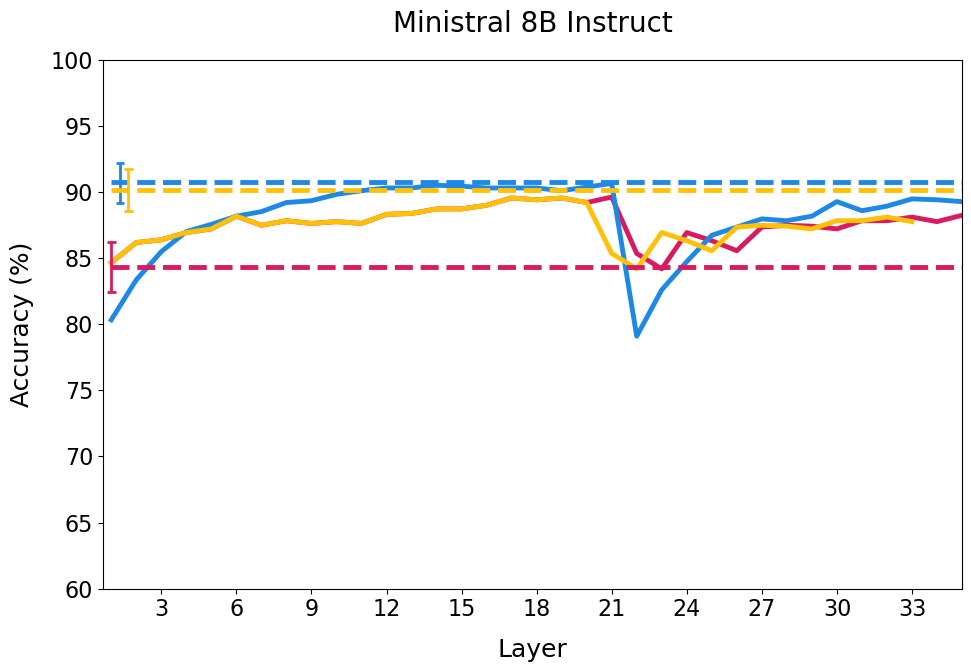

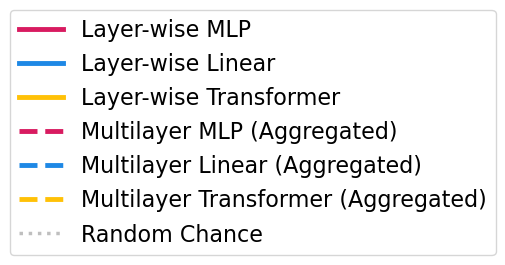

In [67]:
# Step 1: Process the DataFrame into the correct dictionary format
# First extract the data from the DataFrame
def process_probe_dataframe(probe_df, num_layers):
    # Extract layer-wise probe data
    # MLP probes (layer-wise)
    mlp_mask = (probe_df["type of probe"] == "mlp") & (probe_df["layer_nr"] != "multilayer aggregated")
    mlp_accuracies = probe_df[mlp_mask]["accuracy"].to_list()
    mlp_ci_lower = probe_df[mlp_mask]["lower_bound"].to_list()
    mlp_ci_upper = probe_df[mlp_mask]["upper_bound"].to_list()
    mlp_ci = [mlp_ci_lower, mlp_ci_upper]
    
    # Linear probes (layer-wise)
    linear_mask = (probe_df["type of probe"] == "linear") & (probe_df["layer_nr"] != "multilayer aggregated")
    linear_accuracies = probe_df[linear_mask]["accuracy"].to_list()
    linear_ci_lower = probe_df[linear_mask]["lower_bound"].to_list()
    linear_ci_upper = probe_df[linear_mask]["upper_bound"].to_list()
    linear_ci = [linear_ci_lower, linear_ci_upper]
    
    # Transformer probes (layer-wise)
    transformer_mask = (probe_df["type of probe"] == "transformer") & (probe_df["layer_nr"] != "multilayer aggregated")
    transformer_accuracies = probe_df[transformer_mask]["accuracy"].to_list()
    transformer_ci_lower = probe_df[transformer_mask]["lower_bound"].to_list()
    transformer_ci_upper = probe_df[transformer_mask]["upper_bound"].to_list()
    transformer_ci = [transformer_ci_lower, transformer_ci_upper]
    
    # Extract multilayer probe data
    # Multilayer MLP
    mlp_multi_mask = (probe_df["type of probe"] == "mlp") & (probe_df["layer_nr"] == "multilayer aggregated")
    multilayer_mlp_accuracy = probe_df[mlp_multi_mask]["accuracy"].to_list()
    multilayer_mlp_ci_lower = probe_df[mlp_multi_mask]["lower_bound"].to_list()
    multilayer_mlp_ci_upper = probe_df[mlp_multi_mask]["upper_bound"].to_list()
    multilayer_mlp_ci = [multilayer_mlp_ci_lower, multilayer_mlp_ci_upper]
    
    # Multilayer Linear
    linear_multi_mask = (probe_df["type of probe"] == "linear") & (probe_df["layer_nr"] == "multilayer aggregated")
    multilayer_linear_accuracy = probe_df[linear_multi_mask]["accuracy"].to_list()
    multilayer_linear_ci_lower = probe_df[linear_multi_mask]["lower_bound"].to_list()
    multilayer_linear_ci_upper = probe_df[linear_multi_mask]["upper_bound"].to_list()
    multilayer_linear_ci = [multilayer_linear_ci_lower, multilayer_linear_ci_upper]
    
    # Multilayer Transformer
    transformer_multi_mask = (probe_df["type of probe"] == "transformer") & (probe_df["layer_nr"] == "multilayer aggregated")
    multilayer_trans_accuracy = probe_df[transformer_multi_mask]["accuracy"].to_list()
    multilayer_trans_ci_lower = probe_df[transformer_multi_mask]["lower_bound"].to_list()
    multilayer_trans_ci_upper = probe_df[transformer_multi_mask]["upper_bound"].to_list()
    multilayer_trans_ci = [multilayer_trans_ci_lower, multilayer_trans_ci_upper]
    
    # Create the probe_data dictionary with the exact structure expected by the plot function
    probe_data_dict = {
        'Layer-wise MLP': {
            'type': 'layer-wise',
            'accuracies': mlp_accuracies,
            'cis': mlp_ci,
            'color': '#D81B60'  # Bright pink/magenta for MLP probes
        },
        'Layer-wise Linear': {
            'type': 'layer-wise',
            'accuracies': linear_accuracies,
            'cis': linear_ci,
            'color': '#1E88E5'  # Vivid blue for Linear probes
        },
        'Layer-wise Transformer': {
            'type': 'layer-wise',
            'accuracies': transformer_accuracies,
            'cis': transformer_ci,
            'color': '#FFC107'  # Amber/gold for Transformer probes
        },
        'Multilayer MLP (Aggregated)': {
            'type': 'multilayer',
            'accuracies': multilayer_mlp_accuracy,
            'cis': multilayer_mlp_ci,
            'color': '#D81B60'  # Same bright pink/magenta
        },
        'Multilayer Linear (Aggregated)': {
            'type': 'multilayer',
            'accuracies': multilayer_linear_accuracy,
            'cis': multilayer_linear_ci,
            'color': '#1E88E5'  # Same vivid blue
        },
        'Multilayer Transformer (Aggregated)': {
            'type': 'multilayer',
            'accuracies': multilayer_trans_accuracy,
            'cis': multilayer_trans_ci,
            'color': '#FFC107'  # Same amber/gold
        }
    }
    
    return probe_data_dict

# Step 2: Use the processed dictionary in the plot function
# Example usage:

# First get the probe data dictionary from the DataFrame
probe_data_dict = process_probe_dataframe(probe_data, num_layers)

# Define the layers sequence - use only the layers present in the data
# Based on your output, you have data for layers 1-15, so use those

# Example usage:
fig_plot, fig_legend = plot_probe_comparison_split_fixed(
    layers, 
    probe_data_dict, 
    model_name=model_name, 
    save_path=save_path
)

In [68]:
save_path

PosixPath('/data/nathalie_maria_kirch/ERA_Fellowship/images/public_2/accuracy_by_layer/Ministral-8B-Instruct/Ministral-8B-Instruct_probe_comparison_layerwise_multilayer_aggregated_probes_plot.pdf')

In [69]:
def process_probe_dataframe(probe_df, num_layers):
    # Extract aggregated multilayer probe data
    # Multilayer MLP (Aggregated)
    mlp_agg_mask = (probe_df["type of probe"] == "mlp") & (probe_df["layer_nr"] == "multilayer aggregated")
    multilayer_mlp_agg_accuracy = probe_df[mlp_agg_mask]["accuracy"].to_list()
    multilayer_mlp_agg_ci_lower = probe_df[mlp_agg_mask]["lower_bound"].to_list()
    multilayer_mlp_agg_ci_upper = probe_df[mlp_agg_mask]["upper_bound"].to_list()
    multilayer_mlp_agg_ci = [multilayer_mlp_agg_ci_lower, multilayer_mlp_agg_ci_upper]
    
    # Multilayer Linear (Aggregated)
    linear_agg_mask = (probe_df["type of probe"] == "linear") & (probe_df["layer_nr"] == "multilayer aggregated")
    multilayer_linear_agg_accuracy = probe_df[linear_agg_mask]["accuracy"].to_list()
    multilayer_linear_agg_ci_lower = probe_df[linear_agg_mask]["lower_bound"].to_list()
    multilayer_linear_agg_ci_upper = probe_df[linear_agg_mask]["upper_bound"].to_list()
    multilayer_linear_agg_ci = [multilayer_linear_agg_ci_lower, multilayer_linear_agg_ci_upper]
    
    # Multilayer Transformer (Aggregated)
    transformer_agg_mask = (probe_df["type of probe"] == "transformer") & (probe_df["layer_nr"] == "multilayer aggregated")
    multilayer_trans_agg_accuracy = probe_df[transformer_agg_mask]["accuracy"].to_list()
    multilayer_trans_agg_ci_lower = probe_df[transformer_agg_mask]["lower_bound"].to_list()
    multilayer_trans_agg_ci_upper = probe_df[transformer_agg_mask]["upper_bound"].to_list()
    multilayer_trans_agg_ci = [multilayer_trans_agg_ci_lower, multilayer_trans_agg_ci_upper]

    # Extract non-aggregated multilayer probe data
    # Multilayer MLP (Non-Aggregated)
    mlp_non_agg_mask = (probe_df["type of probe"] == "mlp") & (probe_df["layer_nr"] == "multilayer non-aggregated")
    multilayer_mlp_non_agg_accuracy = probe_df[mlp_non_agg_mask]["accuracy"].to_list()
    multilayer_mlp_non_agg_ci_lower = probe_df[mlp_non_agg_mask]["lower_bound"].to_list()
    multilayer_mlp_non_agg_ci_upper = probe_df[mlp_non_agg_mask]["upper_bound"].to_list()
    multilayer_mlp_non_agg_ci = [multilayer_mlp_non_agg_ci_lower, multilayer_mlp_non_agg_ci_upper]

    # Multilayer Linear (Non-Aggregated)
    linear_non_agg_mask = (probe_df["type of probe"] == "linear") & (probe_df["layer_nr"] == "multilayer non-aggregated")
    multilayer_linear_non_agg_accuracy = probe_df[linear_non_agg_mask]["accuracy"].to_list()
    multilayer_linear_non_agg_ci_lower = probe_df[linear_non_agg_mask]["lower_bound"].to_list()
    multilayer_linear_non_agg_ci_upper = probe_df[linear_non_agg_mask]["upper_bound"].to_list()
    multilayer_linear_non_agg_ci = [multilayer_linear_non_agg_ci_lower, multilayer_linear_non_agg_ci_upper]
    
    # Multilayer Transformer (Non-Aggregated)
    transformer_non_agg_mask = (probe_df["type of probe"] == "transformer") & (probe_df["layer_nr"] == "multilayer non-aggregated")
    multilayer_trans_non_agg_accuracy = probe_df[transformer_non_agg_mask]["accuracy"].to_list()
    multilayer_trans_non_agg_ci_lower = probe_df[transformer_non_agg_mask]["lower_bound"].to_list()
    multilayer_trans_non_agg_ci_upper = probe_df[transformer_non_agg_mask]["upper_bound"].to_list()
    multilayer_trans_non_agg_ci = [multilayer_trans_non_agg_ci_lower, multilayer_trans_non_agg_ci_upper]    
    
    # Create the probe_data dictionary with the exact structure expected by the plot function
    probe_data_dict = {
        'Multilayer MLP (Aggregated)': {
            'type': 'multilayer',
            'aggregated': True,
            'accuracies': multilayer_mlp_agg_accuracy,
            'cis': multilayer_mlp_agg_ci,
            'color': '#D81B60'  # Bright pink/magenta
        },
        'Multilayer Linear (Aggregated)': {
            'type': 'multilayer',
            'aggregated': True,
            'accuracies': multilayer_linear_agg_accuracy,
            'cis': multilayer_linear_agg_ci,
            'color': '#1E88E5'  # Vivid blue
        },
        'Multilayer Transformer (Aggregated)': {
            'type': 'multilayer',
            'aggregated': True,
            'accuracies': multilayer_trans_agg_accuracy,
            'cis': multilayer_trans_agg_ci,
            'color': '#FFC107'  # Amber/gold
        },
        'Multilayer MLP (Non-Aggregated)': {
            'type': 'multilayer',
            'aggregated': False,
            'accuracies': multilayer_mlp_non_agg_accuracy,
            'cis': multilayer_mlp_non_agg_ci,
            'color': '#EF8491'  # Same base color as aggregated
        },
        'Multilayer Linear (Non-Aggregated)': {
            'type': 'multilayer',
            'aggregated': False,
            'accuracies': multilayer_linear_non_agg_accuracy,
            'cis': multilayer_linear_non_agg_ci,
            'color': '#4AA3FF'  # Same base color as aggregated
        },  
        'Multilayer Transformer (Non-Aggregated)': {    
            'type': 'multilayer',
            'aggregated': False,
            'accuracies': multilayer_trans_non_agg_accuracy,
            'cis': multilayer_trans_non_agg_ci,
            'color': '#FFD54F'  # Same base color as aggregated
        }
    }
    
    return probe_data_dict


probe_data_dict = process_probe_dataframe(probe_data, num_layers)

Multilayer probe: Multilayer MLP (Aggregated), accuracies: [0.8431911966987621, 0.8858321870701513]
Multilayer probe: Multilayer MLP (Aggregated), CIs: [[0.8245006450301849, 0.8694858128487029], [0.8618817483673392, 0.9021785612915998]]
Multilayer probe: Multilayer Linear (Aggregated), accuracies: [0.905777166437414, 0.904401650618982]
Multilayer probe: Multilayer Linear (Aggregated), CIs: [[0.89, 0.89], [0.92, 0.92]]
Multilayer probe: Multilayer Transformer (Aggregated), accuracies: [0.8975240715268226, 0.875515818431912]
Multilayer probe: Multilayer Transformer (Aggregated), CIs: [[0.8819354450253576, 0.8585465565981321], [0.9131126980282877, 0.8924850802656918]]
Multilayer probe: Multilayer Linear (Non-Aggregated), accuracies: [0.7, 0.7]
Multilayer probe: Multilayer Linear (Non-Aggregated), CIs: [[0.7, 0.8603098848524003], [0.7, 0.8661982579719746]]


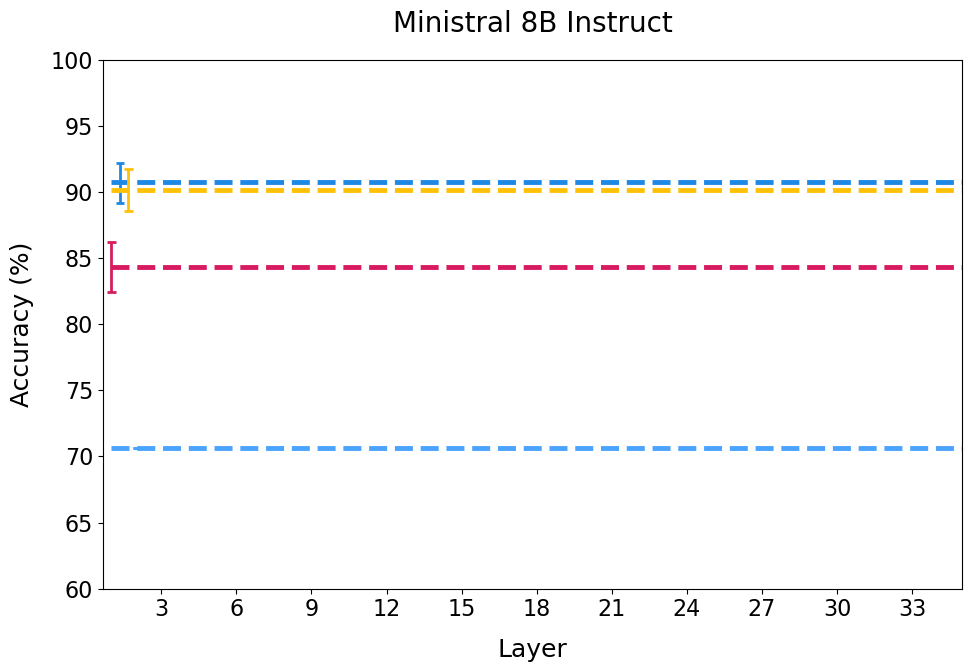

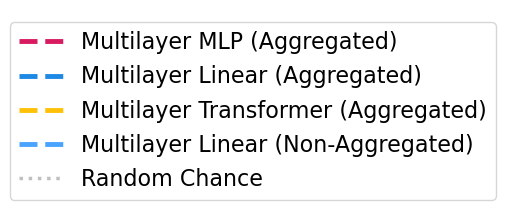

In [70]:
save_path = IMAGES_DIR / f"{publication}/accuracy_by_layer/{model_name}/{model_name}_probe_comparison_multilayer_aggregated_non_aggregated_probes_plot.pdf"

# Example usage:
fig_plot, fig_legend = plot_probe_comparison_split_fixed(
    layers, 
    probe_data_dict, 
    model_name=model_name, 
    save_path=save_path
)